<a href="https://colab.research.google.com/github/patricknzk/GANs-PyTorch/blob/main/GANs_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Adversarial Networks

Welcome to my notebook. Here I will explore General Adversarial Networks, code prepared for my report.

First we load the required dependencies for this notebook.


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import math

##  Part 1: Simple Implementation of GANs

### Step 1: Generate a simple data distribution

We will define two functions, our function y(x) we want to recreate, and x inputs.

In [ ]:
# Generate sine function
def generate_y(x):
    return math.sin(x)

# Generate sample x data
def sample_data(n=32, scale=8):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = generate_y(x[i])
        data.append([x[i], yi])

    return torch.tensor(data).float()

Let's view what we are trying to recreate.


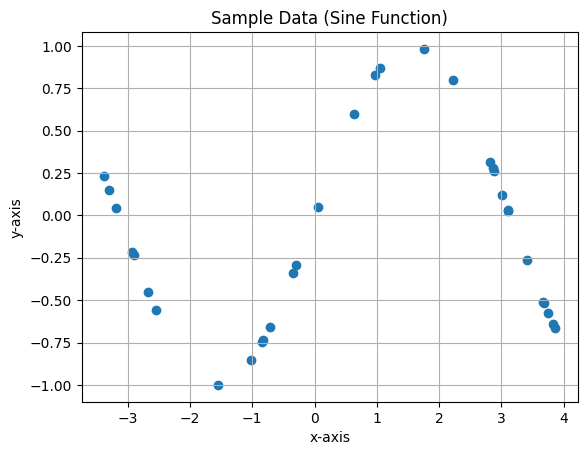

In [ ]:
# Plot sample data
data = sample_data()
plt.scatter(data[:,0], data[:,1])
plt.title('Sample Data (Sine Function)')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.grid(True)
plt.show()

Looks good!

### Step 2: Intialise generator and discriminator networks

First we write up the code for the Generator and Discriminator function.

In [ ]:
class Generator(nn.Module):
    def __init__(self, size = 512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, size),
            nn.LeakyReLU(),
            nn.Linear(size, size),
            nn.LeakyReLU(),
            nn.Linear(size, 2),
        )

    def forward(self, Z):
        return self.net(Z)

class Discriminator(nn.Module):
    def __init__(self, size = 512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, size),
            nn.LeakyReLU(),
            nn.Linear(size, size),
            nn.LeakyReLU(),
            nn.Linear(size, 2),
            nn.Linear(2,1)
        )

    def forward(self, X):
        return self.net(X)

Initialise the two models and use the systems GPU for training.

In [ ]:
# Initialise
generator = Generator().cuda()
discriminator = Discriminator().cuda()

Define our loss function (Binary Cross Entropy) and our optimiser (ADAM)

In [ ]:
# Loss functions & Optimiser functions
loss_fn = nn.BCEWithLogitsLoss()
g_opt = torch.optim.Adam(generator.parameters(), lr=0.00009, betas=(0.5, 0.999))
d_opt = torch.optim.Adam(discriminator.parameters(), lr=0.00009, betas=(0.5, 0.999))

### Step 3: Train models

Define the step function.

1. Train discriminator with fake and real data. Challenge the discriminator to distinguish between the two. Intialise loss as the sum of the loss of the real and fake data.

2. Train genereator function with random variables and calculate the loss by comparing the generated data and real data.

In [ ]:
def train_step(x_real):
    generator.train()
    discriminator.train()
    bs = x_real.size(0)
    x_real = x_real.cuda()

    # train discriminator
    z = torch.randn(bs, 2, device = 'cuda')
    with torch.no_grad():
      x_fake = generator(z)

    d_opt.zero_grad()
    d_real_logit = discriminator(x_real)
    d_fake_logit = discriminator(x_fake)

    real_targets = torch.ones_like(d_real_logit)
    fake_targets = torch.zeros_like(d_fake_logit)

    d_loss = loss_fn(d_real_logit, real_targets) + loss_fn(d_fake_logit, fake_targets)
    d_loss.backward()
    d_opt.step()

    # train generator
    z = torch.randn(bs, 2, device = 'cuda')
    g_opt.zero_grad()
    x_fake = generator(z)
    d_fake_logit = discriminator(x_fake)
    g_loss = loss_fn(d_fake_logit, real_targets)
    g_loss.backward()
    g_opt.step()

    return d_loss.item(), g_loss.item()

Store the loss values and train the models.

In [ ]:
d_losses = []
g_losses = []
for epoch in range(6000):
  d_loss, g_loss = train_step(data)
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  if epoch % 100 == 0:
        print(f"epoch {epoch}: D {d_loss:.3f} | G {g_loss:.3f}")

epoch 0: D 1.444 | G 1.028
epoch 100: D 1.236 | G 1.066
epoch 200: D 1.337 | G 0.701
epoch 300: D 1.337 | G 0.745
epoch 400: D 1.331 | G 0.746
epoch 500: D 1.334 | G 0.741
epoch 600: D 1.359 | G 0.833
epoch 700: D 1.285 | G 0.718
epoch 800: D 1.351 | G 0.749
epoch 900: D 1.327 | G 0.739
epoch 1000: D 1.363 | G 0.734
epoch 1100: D 1.353 | G 0.736
epoch 1200: D 1.356 | G 0.724
epoch 1300: D 1.368 | G 0.771
epoch 1400: D 1.343 | G 0.761
epoch 1500: D 1.361 | G 0.770
epoch 1600: D 1.351 | G 0.743
epoch 1700: D 1.340 | G 0.684
epoch 1800: D 1.356 | G 0.696
epoch 1900: D 1.320 | G 0.704
epoch 2000: D 1.334 | G 0.671
epoch 2100: D 1.336 | G 0.760
epoch 2200: D 1.334 | G 0.712
epoch 2300: D 1.347 | G 0.769
epoch 2400: D 1.374 | G 0.728
epoch 2500: D 1.304 | G 0.732
epoch 2600: D 1.334 | G 0.783
epoch 2700: D 1.334 | G 0.744
epoch 2800: D 1.361 | G 0.815
epoch 2900: D 1.331 | G 0.787
epoch 3000: D 1.351 | G 0.798
epoch 3100: D 1.307 | G 0.812
epoch 3200: D 1.371 | G 0.738
epoch 3300: D 1.292 | 

View the loss curve.

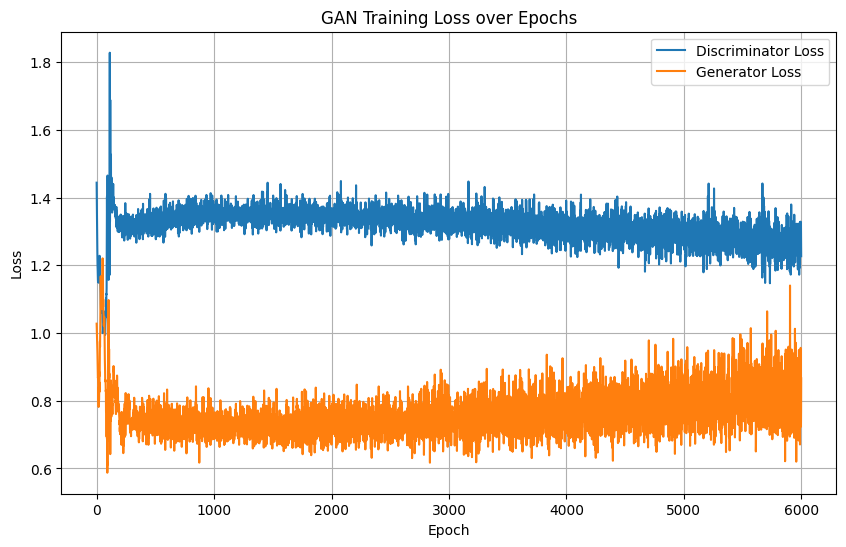

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(d_losses)), d_losses, label='Discriminator Loss')
plt.plot(range(len(g_losses)), g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Step 4: Analysis

Compare real and generated sine function.

In [ ]:
z = torch.randn(128, 2).cuda()

generator.eval()
with torch.no_grad():
  generated_image = generator(z).cpu()

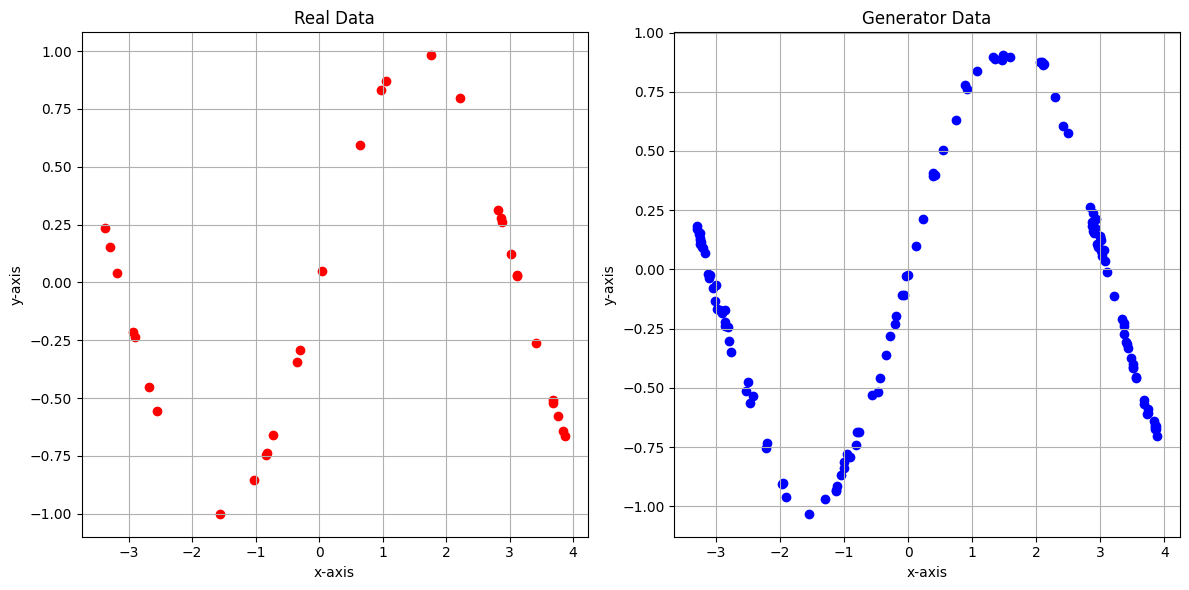

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(data[:,0], data[:,1], c='r')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Real Data')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(generated_image.detach().numpy()[:,0], generated_image.detach().numpy()[:,1], c='b')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Generator Data')
plt.grid(True)

plt.tight_layout()
plt.show()

## Part 2: Application - Writing Digits

### Step 1: Load dependencies + extras

Set seed

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

Initialise parameters

In [ ]:
epochs = 10
img_size = 28
latent_dim = 100
channels = 1
lr = 10**-4
batch_size = 5 # The batch size determines how many data samples are processed in each forward and backward pass during training.
                # A larger batch size can lead to faster convergence but requires more memory.

### Step 2: Load and transform data

In [ ]:
transform = transforms.Compose(
    [transforms.Resize(img_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))] # (x,) intialises a tuple. A single value means it is single channel
)

mnist_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

classes = ('zero', 'one', 'two', 'three', 'four',
           'five', 'six', 'seven', 'eight', 'nine')

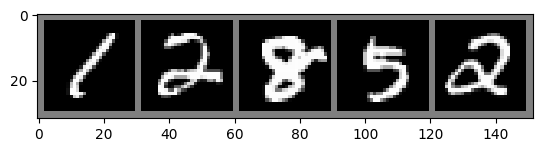

one   two   eight five  two  


In [ ]:
def show_img(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

datair = iter(data_loader)
images, labels = next(datair)

show_img(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Step 3: Develop cGAN and DCGAN for MNIST training

In [ ]:
# deep convolution GAN + conditional
class Generator(nn.Module):
  def __init__(self, latent_dim=100, n_classes=10, embedding_dim=100):
    super(Generator, self).__init__()
    self.label_conditioned_generator = nn.Sequential(
        nn.Embedding(n_classes, embedding_dim),
        nn.Linear(embedding_dim, 7 * 7)  # output size adjusted for MNIST
    )

    self.latent = nn.Sequential(
        nn.Linear(latent_dim, 7 * 7 * 128),# 128 channels with a 7x7 spatial dim
        nn.LeakyReLU(0.2, inplace=True)
    )

    self.model = nn.Sequential(
        nn.ConvTranspose2d(in_channels=128 + 1, out_channels=128, kernel_size=4, stride=2, padding=1), # adjusted in_channels to account for labels.
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(in_channels=128, out_channels=channels, kernel_size=4, stride=2, padding=1),
        nn.Tanh()
    )

  def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 7, 7)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 128, 7, 7)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        return image

class Discriminator(nn.Module):
  def __init__(self, n_classes=10, embedding_dim=100):
    super(Discriminator, self).__init__()

    self.label_condition_disc = nn.Sequential(
        nn.Embedding(n_classes, embedding_dim),
        nn.Linear(embedding_dim, 28 * 28)
    )

    self.model = nn.Sequential(
        nn.Conv2d(in_channels=channels + 1, out_channels=64, kernel_size=3, stride=2, padding=1),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(in_channels=128, out_channels=1, kernel_size=7, stride=1, padding=0),
        nn.Flatten(),
        nn.Sigmoid()
    )

  def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 1, 28, 28)
        concat = torch.cat((img, label_output), dim=1)
        output = self.model(concat)
        return output

In [ ]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [ ]:
loss_fn = nn.BCELoss()
opt_g = torch.optim.Adam(generator.parameters(), lr=lr)
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr)

### Step 4: Develop and run training loop.

Epochs [1/10], Batch[100/12000],D_real: 0.8205, D_fake: 0.2322, Loss_D: 0.4841, Loss_G: 1.9708
Epochs [1/10], Batch[200/12000],D_real: 0.7405, D_fake: 0.3778, Loss_D: 0.8836, Loss_G: 1.4854
Epochs [1/10], Batch[300/12000],D_real: 0.8673, D_fake: 0.1600, Loss_D: 0.3232, Loss_G: 2.2560
Epochs [1/10], Batch[400/12000],D_real: 0.7514, D_fake: 0.1145, Loss_D: 0.4168, Loss_G: 2.1511
Epochs [1/10], Batch[500/12000],D_real: 0.6452, D_fake: 0.2560, Loss_D: 0.7844, Loss_G: 1.4284
Epochs [1/10], Batch[600/12000],D_real: 0.8189, D_fake: 0.3273, Loss_D: 0.6330, Loss_G: 0.7502
Epochs [1/10], Batch[700/12000],D_real: 0.5994, D_fake: 0.4521, Loss_D: 1.1899, Loss_G: 0.9987
Epochs [1/10], Batch[800/12000],D_real: 0.8417, D_fake: 0.1732, Loss_D: 0.3811, Loss_G: 1.5170
Epochs [1/10], Batch[900/12000],D_real: 0.8056, D_fake: 0.2522, Loss_D: 0.5526, Loss_G: 0.9280
Epochs [1/10], Batch[1000/12000],D_real: 0.8623, D_fake: 0.2297, Loss_D: 0.4391, Loss_G: 1.2656
Epochs [1/10], Batch[1100/12000],D_real: 0.4775, 

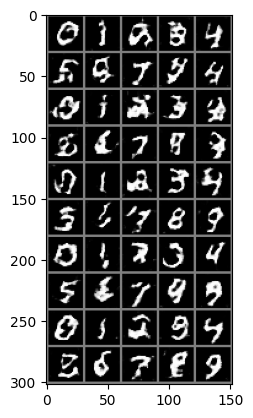

Epochs [2/10], Batch[100/12000],D_real: 0.9915, D_fake: 0.0074, Loss_D: 0.0160, Loss_G: 5.9608
Epochs [2/10], Batch[200/12000],D_real: 0.9922, D_fake: 0.0182, Loss_D: 0.0263, Loss_G: 5.9274
Epochs [2/10], Batch[300/12000],D_real: 0.9992, D_fake: 0.0086, Loss_D: 0.0095, Loss_G: 2.1388
Epochs [2/10], Batch[400/12000],D_real: 0.9886, D_fake: 0.0383, Loss_D: 0.0516, Loss_G: 3.6664
Epochs [2/10], Batch[500/12000],D_real: 0.9981, D_fake: 0.0209, Loss_D: 0.0233, Loss_G: 3.2297
Epochs [2/10], Batch[600/12000],D_real: 0.8399, D_fake: 0.0113, Loss_D: 0.1920, Loss_G: 5.3029
Epochs [2/10], Batch[700/12000],D_real: 0.7001, D_fake: 0.0055, Loss_D: 0.4126, Loss_G: 6.1487
Epochs [2/10], Batch[800/12000],D_real: 0.9797, D_fake: 0.1422, Loss_D: 0.1909, Loss_G: 2.1591
Epochs [2/10], Batch[900/12000],D_real: 0.4770, D_fake: 0.0330, Loss_D: 0.8049, Loss_G: 4.4403
Epochs [2/10], Batch[1000/12000],D_real: 0.8923, D_fake: 0.0019, Loss_D: 0.1203, Loss_G: 5.1595
Epochs [2/10], Batch[1100/12000],D_real: 0.8160, 

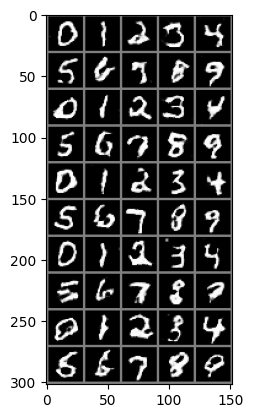

Epochs [3/10], Batch[100/12000],D_real: 0.9560, D_fake: 0.4361, Loss_D: 0.6697, Loss_G: 3.9329
Epochs [3/10], Batch[200/12000],D_real: 0.9968, D_fake: 0.0233, Loss_D: 0.0268, Loss_G: 1.8671
Epochs [3/10], Batch[300/12000],D_real: 0.3071, D_fake: 0.0684, Loss_D: 1.3245, Loss_G: 1.6472
Epochs [3/10], Batch[400/12000],D_real: 0.9480, D_fake: 0.0167, Loss_D: 0.0709, Loss_G: 4.5942
Epochs [3/10], Batch[500/12000],D_real: 0.5927, D_fake: 0.0071, Loss_D: 0.5988, Loss_G: 6.1144
Epochs [3/10], Batch[600/12000],D_real: 0.9949, D_fake: 0.2438, Loss_D: 0.2969, Loss_G: 0.8831
Epochs [3/10], Batch[700/12000],D_real: 0.9375, D_fake: 0.0154, Loss_D: 0.0810, Loss_G: 3.7676
Epochs [3/10], Batch[800/12000],D_real: 0.8298, D_fake: 0.0009, Loss_D: 0.1929, Loss_G: 5.9588
Epochs [3/10], Batch[900/12000],D_real: 0.7952, D_fake: 0.0557, Loss_D: 0.3003, Loss_G: 3.6396
Epochs [3/10], Batch[1000/12000],D_real: 0.9994, D_fake: 0.0968, Loss_D: 0.1060, Loss_G: 2.8533
Epochs [3/10], Batch[1100/12000],D_real: 0.9919, 

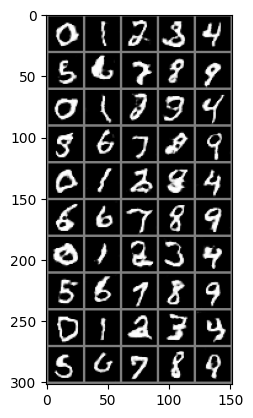

Epochs [4/10], Batch[100/12000],D_real: 0.9236, D_fake: 0.0142, Loss_D: 0.0944, Loss_G: 6.4988
Epochs [4/10], Batch[200/12000],D_real: 0.7979, D_fake: 0.2028, Loss_D: 0.4817, Loss_G: 3.1354
Epochs [4/10], Batch[300/12000],D_real: 0.2934, D_fake: 0.0036, Loss_D: 1.3189, Loss_G: 3.9916
Epochs [4/10], Batch[400/12000],D_real: 0.9863, D_fake: 0.2234, Loss_D: 0.2819, Loss_G: 0.8546
Epochs [4/10], Batch[500/12000],D_real: 0.9996, D_fake: 0.1619, Loss_D: 0.1836, Loss_G: 1.8830
Epochs [4/10], Batch[600/12000],D_real: 0.9987, D_fake: 0.0306, Loss_D: 0.0328, Loss_G: 0.2596
Epochs [4/10], Batch[700/12000],D_real: 0.9948, D_fake: 0.2605, Loss_D: 0.3513, Loss_G: 4.2031
Epochs [4/10], Batch[800/12000],D_real: 0.9984, D_fake: 0.1653, Loss_D: 0.1947, Loss_G: 3.4460
Epochs [4/10], Batch[900/12000],D_real: 0.9595, D_fake: 0.1937, Loss_D: 0.2715, Loss_G: 2.6893
Epochs [4/10], Batch[1000/12000],D_real: 0.9701, D_fake: 0.0496, Loss_D: 0.0819, Loss_G: 6.2662
Epochs [4/10], Batch[1100/12000],D_real: 0.9824, 

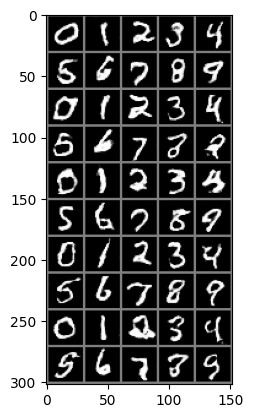

Epochs [5/10], Batch[100/12000],D_real: 0.9734, D_fake: 0.0073, Loss_D: 0.0347, Loss_G: 4.6321
Epochs [5/10], Batch[200/12000],D_real: 0.9919, D_fake: 0.1167, Loss_D: 0.1414, Loss_G: 0.6365
Epochs [5/10], Batch[300/12000],D_real: 0.9451, D_fake: 0.0571, Loss_D: 0.1180, Loss_G: 1.8329
Epochs [5/10], Batch[400/12000],D_real: 0.9524, D_fake: 0.0539, Loss_D: 0.1060, Loss_G: 2.4620
Epochs [5/10], Batch[500/12000],D_real: 0.8377, D_fake: 0.0371, Loss_D: 0.2209, Loss_G: 1.6042
Epochs [5/10], Batch[600/12000],D_real: 0.9025, D_fake: 0.0640, Loss_D: 0.1742, Loss_G: 4.6649
Epochs [5/10], Batch[700/12000],D_real: 0.9095, D_fake: 0.0400, Loss_D: 0.1432, Loss_G: 1.5784
Epochs [5/10], Batch[800/12000],D_real: 0.8624, D_fake: 0.0404, Loss_D: 0.1949, Loss_G: 2.9926
Epochs [5/10], Batch[900/12000],D_real: 0.9973, D_fake: 0.1147, Loss_D: 0.1276, Loss_G: 3.1013
Epochs [5/10], Batch[1000/12000],D_real: 0.8219, D_fake: 0.0230, Loss_D: 0.2269, Loss_G: 5.1064
Epochs [5/10], Batch[1100/12000],D_real: 0.4279, 

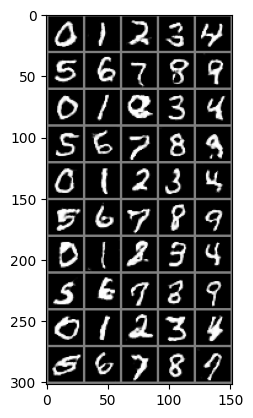

Epochs [6/10], Batch[100/12000],D_real: 0.9996, D_fake: 0.3154, Loss_D: 0.3913, Loss_G: 1.0635
Epochs [6/10], Batch[200/12000],D_real: 0.9969, D_fake: 0.1466, Loss_D: 0.1689, Loss_G: 3.0016
Epochs [6/10], Batch[300/12000],D_real: 0.8872, D_fake: 0.0424, Loss_D: 0.1688, Loss_G: 2.4332
Epochs [6/10], Batch[400/12000],D_real: 0.9988, D_fake: 0.2319, Loss_D: 0.3182, Loss_G: 0.6819
Epochs [6/10], Batch[500/12000],D_real: 0.9698, D_fake: 0.0791, Loss_D: 0.1219, Loss_G: 1.2083
Epochs [6/10], Batch[600/12000],D_real: 0.9237, D_fake: 0.0048, Loss_D: 0.0889, Loss_G: 5.5748
Epochs [6/10], Batch[700/12000],D_real: 0.9688, D_fake: 0.1074, Loss_D: 0.1496, Loss_G: 4.0056
Epochs [6/10], Batch[800/12000],D_real: 0.9956, D_fake: 0.0428, Loss_D: 0.0485, Loss_G: 3.5813
Epochs [6/10], Batch[900/12000],D_real: 0.9999, D_fake: 0.0409, Loss_D: 0.0424, Loss_G: 2.0150
Epochs [6/10], Batch[1000/12000],D_real: 0.9818, D_fake: 0.0429, Loss_D: 0.0628, Loss_G: 1.9376
Epochs [6/10], Batch[1100/12000],D_real: 0.9701, 

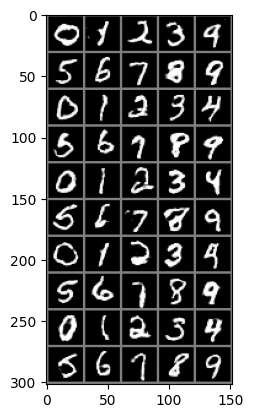

Epochs [7/10], Batch[100/12000],D_real: 0.9809, D_fake: 0.1678, Loss_D: 0.2116, Loss_G: 4.2212
Epochs [7/10], Batch[200/12000],D_real: 0.7070, D_fake: 0.0204, Loss_D: 0.3934, Loss_G: 3.4948
Epochs [7/10], Batch[300/12000],D_real: 0.9611, D_fake: 0.0608, Loss_D: 0.1035, Loss_G: 3.1019
Epochs [7/10], Batch[400/12000],D_real: 0.9936, D_fake: 0.1135, Loss_D: 0.1409, Loss_G: 2.6726
Epochs [7/10], Batch[500/12000],D_real: 0.9964, D_fake: 0.1160, Loss_D: 0.1278, Loss_G: 5.0869
Epochs [7/10], Batch[600/12000],D_real: 0.9990, D_fake: 0.0943, Loss_D: 0.1028, Loss_G: 3.2085
Epochs [7/10], Batch[700/12000],D_real: 0.3504, D_fake: 0.0083, Loss_D: 1.2909, Loss_G: 4.4344
Epochs [7/10], Batch[800/12000],D_real: 0.9790, D_fake: 0.0583, Loss_D: 0.0830, Loss_G: 3.9457
Epochs [7/10], Batch[900/12000],D_real: 0.6300, D_fake: 0.1071, Loss_D: 0.6183, Loss_G: 1.5323
Epochs [7/10], Batch[1000/12000],D_real: 0.9963, D_fake: 0.0081, Loss_D: 0.0119, Loss_G: 4.2986
Epochs [7/10], Batch[1100/12000],D_real: 0.9830, 

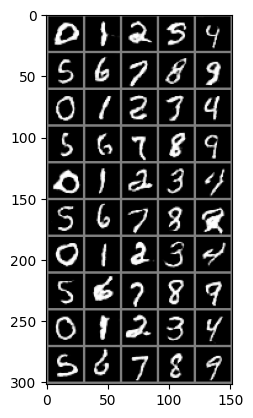

Epochs [8/10], Batch[100/12000],D_real: 0.9982, D_fake: 0.0350, Loss_D: 0.0381, Loss_G: 3.2607
Epochs [8/10], Batch[200/12000],D_real: 0.9991, D_fake: 0.0239, Loss_D: 0.0253, Loss_G: 1.1489
Epochs [8/10], Batch[300/12000],D_real: 0.8288, D_fake: 0.1651, Loss_D: 0.4012, Loss_G: 2.4127
Epochs [8/10], Batch[400/12000],D_real: 0.9875, D_fake: 0.0280, Loss_D: 0.0412, Loss_G: 2.8825
Epochs [8/10], Batch[500/12000],D_real: 0.9998, D_fake: 0.0873, Loss_D: 0.1024, Loss_G: 4.1981
Epochs [8/10], Batch[600/12000],D_real: 0.8553, D_fake: 0.1647, Loss_D: 0.3803, Loss_G: 2.2299
Epochs [8/10], Batch[700/12000],D_real: 0.9904, D_fake: 0.2571, Loss_D: 0.3413, Loss_G: 2.8976
Epochs [8/10], Batch[800/12000],D_real: 0.9832, D_fake: 0.0727, Loss_D: 0.0933, Loss_G: 7.2021
Epochs [8/10], Batch[900/12000],D_real: 0.8876, D_fake: 0.0573, Loss_D: 0.1901, Loss_G: 2.5639
Epochs [8/10], Batch[1000/12000],D_real: 0.8635, D_fake: 0.0084, Loss_D: 0.1592, Loss_G: 4.6665
Epochs [8/10], Batch[1100/12000],D_real: 0.8034, 

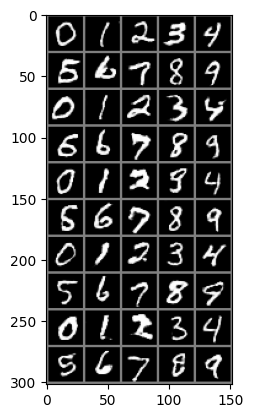

Epochs [9/10], Batch[100/12000],D_real: 0.9488, D_fake: 0.0080, Loss_D: 0.0614, Loss_G: 5.6201
Epochs [9/10], Batch[200/12000],D_real: 0.9661, D_fake: 0.6757, Loss_D: 1.4626, Loss_G: 0.5415
Epochs [9/10], Batch[300/12000],D_real: 0.9310, D_fake: 0.0543, Loss_D: 0.1299, Loss_G: 2.3540
Epochs [9/10], Batch[400/12000],D_real: 0.9969, D_fake: 0.0532, Loss_D: 0.0587, Loss_G: 2.2632
Epochs [9/10], Batch[500/12000],D_real: 1.0000, D_fake: 0.0194, Loss_D: 0.0197, Loss_G: 1.6344
Epochs [9/10], Batch[600/12000],D_real: 0.9850, D_fake: 0.0128, Loss_D: 0.0282, Loss_G: 4.3885
Epochs [9/10], Batch[700/12000],D_real: 0.5443, D_fake: 0.0015, Loss_D: 0.6557, Loss_G: 1.1136
Epochs [9/10], Batch[800/12000],D_real: 0.5741, D_fake: 0.0294, Loss_D: 0.6781, Loss_G: 6.4683
Epochs [9/10], Batch[900/12000],D_real: 0.9601, D_fake: 0.0040, Loss_D: 0.0452, Loss_G: 5.6812
Epochs [9/10], Batch[1000/12000],D_real: 0.9947, D_fake: 0.3575, Loss_D: 0.4985, Loss_G: 6.8115
Epochs [9/10], Batch[1100/12000],D_real: 0.9977, 

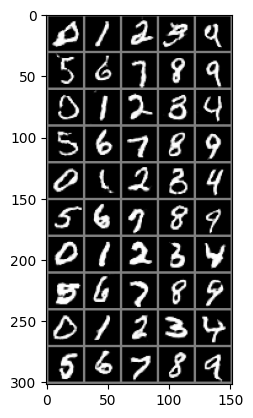

Epochs [10/10], Batch[100/12000],D_real: 0.9587, D_fake: 0.1952, Loss_D: 0.2819, Loss_G: 4.1579
Epochs [10/10], Batch[200/12000],D_real: 0.9999, D_fake: 0.1552, Loss_D: 0.1925, Loss_G: 2.6536
Epochs [10/10], Batch[300/12000],D_real: 0.9894, D_fake: 0.0030, Loss_D: 0.0138, Loss_G: 4.3242
Epochs [10/10], Batch[400/12000],D_real: 0.9727, D_fake: 0.0108, Loss_D: 0.0388, Loss_G: 3.6247
Epochs [10/10], Batch[500/12000],D_real: 0.9996, D_fake: 0.0105, Loss_D: 0.0110, Loss_G: 3.4436
Epochs [10/10], Batch[600/12000],D_real: 0.9777, D_fake: 0.0410, Loss_D: 0.0648, Loss_G: 1.2049
Epochs [10/10], Batch[700/12000],D_real: 0.9987, D_fake: 0.2935, Loss_D: 0.3874, Loss_G: 4.2323
Epochs [10/10], Batch[800/12000],D_real: 0.8249, D_fake: 0.0413, Loss_D: 0.2668, Loss_G: 2.0855
Epochs [10/10], Batch[900/12000],D_real: 0.6811, D_fake: 0.0368, Loss_D: 0.5177, Loss_G: 4.3622
Epochs [10/10], Batch[1000/12000],D_real: 0.9248, D_fake: 0.0041, Loss_D: 0.0832, Loss_G: 3.8018
Epochs [10/10], Batch[1100/12000],D_rea

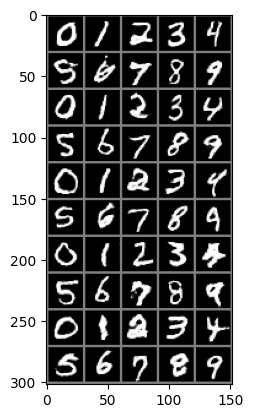

In [ ]:
for epoch in range(epochs):
  for i, (images, labels) in enumerate(data_loader):
    images = images.cuda()
    labels = labels.cuda()
    batch_size = images.size(0)

    # train d
    opt_d.zero_grad()
    labels_r = torch.ones(batch_size, 1).cuda()
    output_r = discriminator((images, labels)).view(-1,1)
    loss_r = loss_fn(output_r, labels_r)
    loss_r.backward()

    # train d w/ fake
    z = torch.randn(batch_size, latent_dim).cuda()
    random_labels = torch.randint(0, 10, (batch_size,), device='cuda')
    images_f = generator((z, random_labels))
    label_f = torch.zeros(batch_size, 1).cuda() # target for fake data should be 0
    output_f = discriminator((images_f.detach(), random_labels)).view(-1,1)
    loss_f = loss_fn(output_f, label_f)
    loss_f.backward()
    opt_d.step()

    # train g
    opt_g.zero_grad()
    z = torch.randn(batch_size, latent_dim).cuda()
    random_labels = torch.randint(0, 10, (batch_size,), device='cuda')
    images_f = generator((z, random_labels))
    output = discriminator((images_f, random_labels)).view(-1,1)
    loss_g = loss_fn(output, labels_r) # generator wants discriminator to think fakes are real, so target is 1
    loss_g.backward()
    opt_g.step()

    if (i+1)%100 == 0:
      print(f'Epochs [{epoch+1}/{epochs}], Batch[{i+1}/{len(data_loader)}],'
            f'D_real: {output_r.mean():.4f}, D_fake: {output_f.mean():.4f}, '
            f'Loss_D: {loss_r.item() + loss_f.item():.4f}, Loss_G: {loss_g.item():.4f}')
  with torch.no_grad():
    # 5 samples for viewing during training
    fixed_noise = torch.randn(10 * 5, latent_dim).cuda()
    fixed_labels = torch.arange(0, 10).repeat(5).cuda()
    samples_f = generator((fixed_noise, fixed_labels))
    samples_f = samples_f.cpu()
    show_img(torchvision.utils.make_grid(samples_f, nrow=5))

### Step 5: Define a function which generates desired digits

In [ ]:
def generate_digit(*digit_names):
    digit_map = {
        'zero': 0, 'one': 1, 'two': 2, 'three': 3, 'four': 4,
        'five': 5, 'six': 6, 'seven': 7, 'eight': 8, 'nine': 9
    }

    generated_images = []
    for digit_name in digit_names:

        label = torch.tensor([digit_map[digit_name]], device='cuda')
        z = torch.randn(1, latent_dim, device='cuda')

        generator.eval()
        with torch.no_grad():
            generated_image = generator((z, label)).cpu()
        generated_images.append(generated_image)

    if generated_images:
        display_grid = torch.cat(generated_images, dim=0)
        show_img(torchvision.utils.make_grid(display_grid, nrow=len(generated_images)))

Step 6: Generate digits

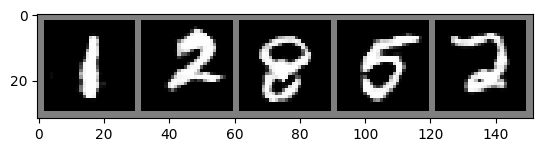

In [ ]:
generate_digit('one', 'two', 'eight', 'five', 'two')